# GradCAM - Gradient Class Activation Map

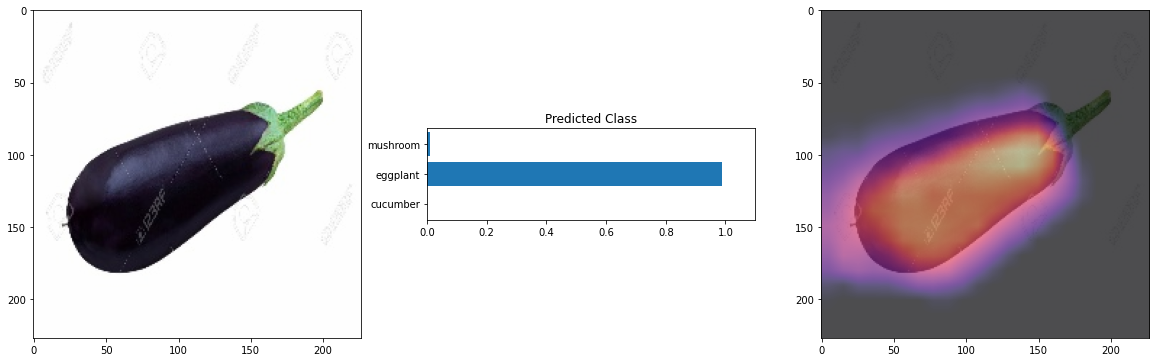

In [1]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 2.59 MiB | 33.97 MiB/s, done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-ju5keq30
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-ju5keq30
  Resolved https://github.com/albumentations-team/albumentations to commit bc42cc74122bf024ff0729d995372666897aed08
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for albumentations: filename=albumentations-1.4.12-py3-none-any.whl size=171495 sha256=7f38f5c83ccdeb147b95c11dde55b67c3fcfc522ab2516945816f44a47d1171c
  Stored in directory: /tmp/pip-ephem-wheel-ca

# Imports

In [2]:
import sys
sys.path.append('/content/GradCAM-Dataset')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [4]:
CSV_FILE = '/content/GradCAM-Dataset/train.csv'
DATA_DIR = '/content/GradCAM-Dataset/'
DEVICE =  'cuda' if torch.cuda.is_available() else 'cpu'

BATCH_SIZE = 16
LR = 0.001
EPOCHS = 20

In [5]:
data = pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [6]:
# cucumber - 0, eggplant - 1, mushroom - 2

train_df, valid_df = train_test_split(data, test_size=0.2, random_state=42)

# Augmentations

In [7]:
train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(0.5),
    A.VerticalFlip(0.5),
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

])

valid_augs = A.Compose([
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Load Image Dataset

In [8]:
trainset = utils.ImageDataset(train_df, augs=train_augs, data_dir=DATA_DIR)
validset = utils.ImageDataset(valid_df, augs=valid_augs, data_dir=DATA_DIR)

Image shape : torch.Size([3, 227, 227])
Label : mushroom


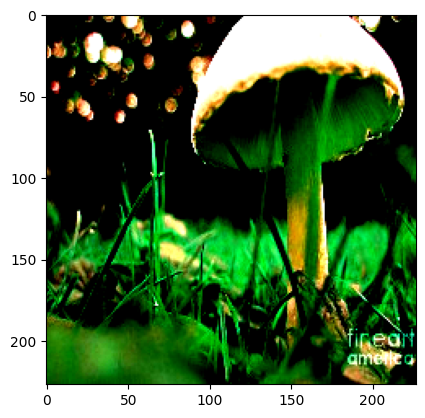

In [9]:
image, label = validset[31]
class_list = ['cucumber', 'eggplant', 'mushroom']
print(f"Image shape : {image.shape}")
print(f"Label : {class_list[label]}")

plt.imshow(image.permute(1,2,0))

In [10]:
print(f"No. of examples in the {len(trainset)}")
print(f"No. of examples in the {len(validset)}")

No. of examples in the 148
No. of examples in the 38


# Load Dataset into Batches

In [11]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [13]:
for images, labels in trainloader:
  break

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


# Create Model

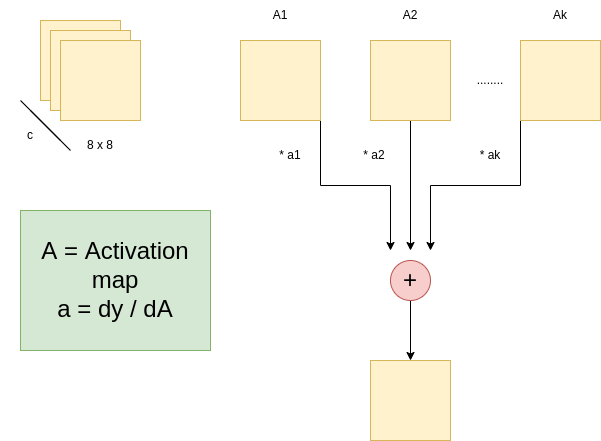

In [26]:
import torch
import torch.nn as nn

class ImageModel(nn.Module):
    def __init__(self):
        super(ImageModel, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), padding=1),
            nn.ReLU()
        )

        self.maxpool = nn.MaxPool2d(kernel_size=(4, 4), stride=2)


        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(6400, 2048),
            nn.ReLU(),
            nn.Linear(2048, 3)
        )

        self.gradient = None

    def activations_hook(self, grad):
        self.gradient = grad

    def forward(self, images):
        x = self.feature_extractor(images)
        h = x.register_hook(self.activations_hook)
        x = self.maxpool(x)
        x = self.classifier(x)
        return x

    def get_activations_gradient(self):
        return self.gradient

    def get_activations(self, x):
        return self.feature_extractor(x)





In [27]:
model = ImageModel()
model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [32]:
def trainfn(dataloader, model, optimizer, criterion):

  model.train()
  total_loss = 0.0

  for images, labels in tqdm(dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    logits = model(images)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [35]:
def evalfn(dataloader, model, criterion):

  model.eval()
  total_loss = 0.0

  for images, labels in tqdm(dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    logits = model(images)
    loss = criterion(logits, labels)

    total_loss += loss.item()

  return total_loss / len(dataloader)

# Training Loop

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr= LR)
criterion = nn.CrossEntropyLoss()

In [57]:
best_valid_loss = np.Inf

for epoch in range(EPOCHS):
  train_loss = trainfn(trainloader, model, optimizer, criterion)
  valid_loss = evalfn(validloader, model, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print("Weights seaved successfully!")

  print(f"Epoch: {epoch+1}/{EPOCHS}")
  print(f"Train Loss: {train_loss:.4f}", f"Valid Loss: {valid_loss:.4f}")

100%|██████████| 3/3 [00:00<00:00, 44.93it/s]


Weights seaved successfully!
Epoch: 1/20
Train Loss: 0.1756 Valid Loss: 0.3749


100%|██████████| 3/3 [00:00<00:00, 42.52it/s]


Epoch: 2/20
Train Loss: 0.1473 Valid Loss: 0.5914


100%|██████████| 3/3 [00:00<00:00, 35.90it/s]


Epoch: 3/20
Train Loss: 0.1074 Valid Loss: 1.0839


100%|██████████| 3/3 [00:00<00:00, 46.68it/s]


Weights seaved successfully!
Epoch: 4/20
Train Loss: 0.0381 Valid Loss: 0.1658


100%|██████████| 3/3 [00:00<00:00, 32.84it/s]


Epoch: 5/20
Train Loss: 0.0424 Valid Loss: 0.4795


100%|██████████| 3/3 [00:00<00:00, 31.86it/s]


Epoch: 6/20
Train Loss: 0.0392 Valid Loss: 0.4973


100%|██████████| 3/3 [00:00<00:00, 31.24it/s]


Weights seaved successfully!
Epoch: 7/20
Train Loss: 0.0933 Valid Loss: 0.0513


100%|██████████| 3/3 [00:00<00:00, 43.92it/s]


Epoch: 8/20
Train Loss: 0.0983 Valid Loss: 0.0769


100%|██████████| 3/3 [00:00<00:00, 46.58it/s]


Epoch: 9/20
Train Loss: 0.0771 Valid Loss: 0.3180


100%|██████████| 3/3 [00:00<00:00, 41.59it/s]


Epoch: 10/20
Train Loss: 0.0755 Valid Loss: 0.0997


100%|██████████| 3/3 [00:00<00:00, 46.30it/s]


Epoch: 11/20
Train Loss: 0.2028 Valid Loss: 0.3800


100%|██████████| 3/3 [00:00<00:00, 42.08it/s]


Epoch: 12/20
Train Loss: 0.3848 Valid Loss: 0.4178


100%|██████████| 3/3 [00:00<00:00, 44.89it/s]


Epoch: 13/20
Train Loss: 0.1950 Valid Loss: 0.2074


100%|██████████| 3/3 [00:00<00:00, 45.25it/s]


Epoch: 14/20
Train Loss: 0.0969 Valid Loss: 0.2762


100%|██████████| 3/3 [00:00<00:00, 40.00it/s]


Epoch: 15/20
Train Loss: 0.0495 Valid Loss: 0.3567


100%|██████████| 3/3 [00:00<00:00, 39.39it/s]


Weights seaved successfully!
Epoch: 16/20
Train Loss: 0.0368 Valid Loss: 0.0341


100%|██████████| 3/3 [00:00<00:00, 38.99it/s]


Epoch: 17/20
Train Loss: 0.0404 Valid Loss: 0.7309


100%|██████████| 3/3 [00:00<00:00, 47.29it/s]


Epoch: 18/20
Train Loss: 0.0363 Valid Loss: 0.1265


100%|██████████| 3/3 [00:00<00:00, 46.39it/s]


Weights seaved successfully!
Epoch: 19/20
Train Loss: 0.0209 Valid Loss: 0.0142


100%|██████████| 3/3 [00:00<00:00, 43.52it/s]

Epoch: 20/20
Train Loss: 0.0125 Valid Loss: 0.0247


# Get GradCAM

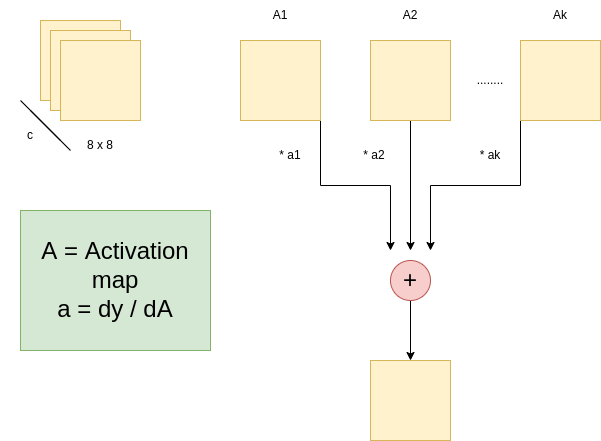

In [40]:
def get_gradcam(model, image, label, size):
  label.backward()
  gradients = model.get_activations_gradient()
  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
  activations = model.get_activations(image).detach()

  for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

  heatmap = torch.mean(activations, dim=1).squeeze().cpu()
  heatmap = nn.ReLU()(heatmap)
  heatmap /= torch.max(heatmap)

  heatmap = cv2.resize(heatmap.numpy(), (size, size))

  return heatmap

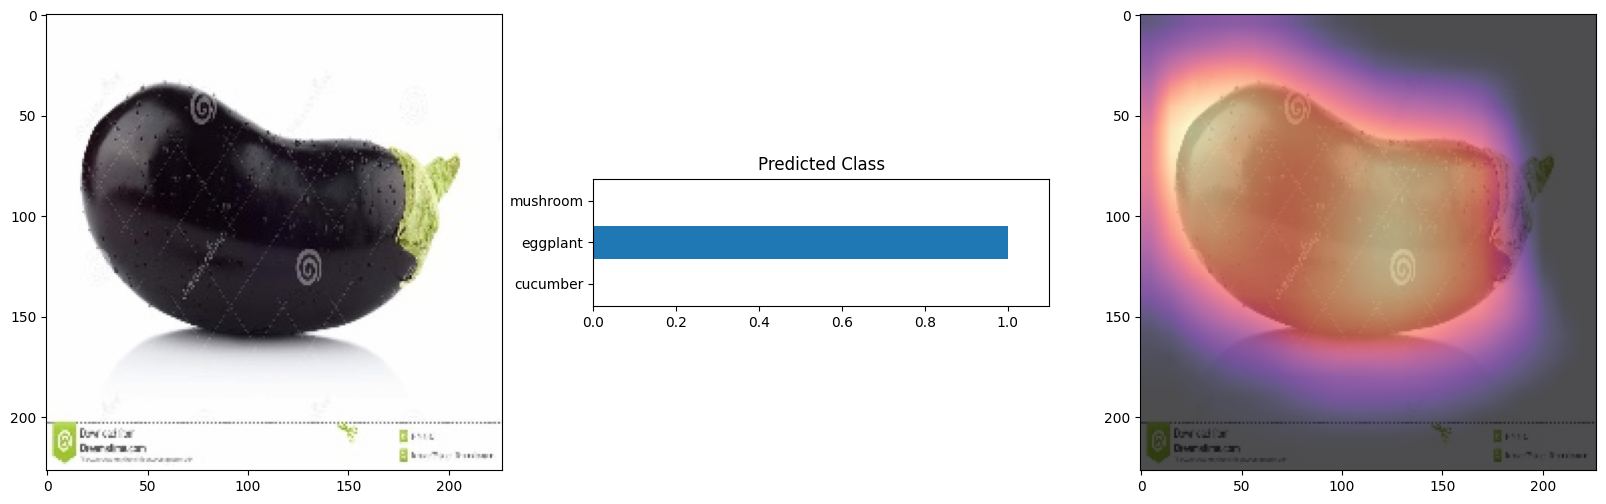

In [56]:
image, label = validset[13]

denorm_image = image.permute(1, 2, 0)*np.array((0.229, 0.224, 0.225))+np.array((0.485, 0.455, 0.406))

image = image.unsqueeze(0).to(DEVICE)

pred = model(image)
heatmap = get_gradcam(model, image, pred[0][1], size=227)

utils.plot_heatmap(denorm_image, pred, heatmap)

GradCam function sucessfully highlights parts of the image which have led Neural Network to classify the image as a eggplant.